In [1]:
import os
import warnings

import astropy.coordinates as coord
from astropy.io.fits.column import VerifyWarning
coord.galactocentric_frame_defaults.set('v4.0')
import astropy.table as at
import astropy.units as u
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

# gala
import gala.coordinates as gc
import gala.dynamics as gd
import gala.integrate as gi
import gala.potential as gp
from gala.units import galactic

from pyia import GaiaData

# Shut up, FITS!
warnings.filterwarnings('ignore', category=VerifyWarning)

In [466]:
g = GaiaData(at.Table.read('../data/all_stars_near_theOG.csv', format='ascii.ecsv'))
g = g[g.prob > 0.5]

tmass = at.Table.read('../data/TheOGGroup-2mass.csv')
g = GaiaData(at.join(g.data, tmass, keys='source_id', 
                     uniq_col_name='{col_name}{table_name}', table_names=['', '2']))

len(g)

65

In [467]:
h = at.QTable.read('../data/hip_stars_near_theOG.csv', format='ascii.ecsv')
h = h[h['prob'] > 0.5]

In [468]:
hbv = h['B-V'].value
hmhp = h['Hpmag'].value - coord.Distance(parallax=h['Plx']).distmod.value

h[(hmhp < 2.05) & (hbv < 0.5)]

HIP,n_HIP,Sn,So,Nc,RArad,e_RArad,DErad,e_DErad,Plx,e_Plx,pmRA,e_pmRA,pmDE,e_pmDE,Ntr,F2,var,Hpmag,e_Hpmag,sHp,VA,B-V,e_B-V,V-I,HIP1,Phot,RV,e_RV,q_RV,plx,e_plx,Hpmag_2,C,Sigma,f_Sigma,Sig_med,Sig_min,mu_Sig,sig_Sig,c_G_,sig68G,sig95G,sig99G,c_rob_,sig68rob,sig95rob,sig99rob,Simbad,_RA,_DE,prob,n_HIP_2,HD,o_RV,Vmag,HIPdata
,,,,,deg,mas,deg,mas,mas,mas,mas / yr,mas / yr,mas / yr,mas / yr,,,,mag,mag,mag,,mag,mag,mag,,,km / s,km / s,,mas,mas,mag,uas / (km s yr),km / s,,km / s,km / s,km / s,km / s,%,km / s,km / s,km / s,%,km / s,km / s,km / s,,deg,deg,,,,,mag,
int32,str1,int16,uint8,uint8,float64,float32,float64,float32,float32,float32,float64,float32,float64,float32,int16,float32,float32,float32,float32,float32,uint8,float32,float32,float32,str4,str4,float64,float64,int64,float32,float32,float64,float64,float64,int16,float64,float64,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,str6,float64,float64,float64,str1,int32,int16,float32,str3
59819,--,5,0,1,184.00097877,0.17,14.89914497,0.12,16.42,0.20,-81.53,0.24,-31.12,0.12,105,-2.20,0.0,5.1214,0.0006,0.006,0,0.068,0.004,0.080,HIP1,Phot,9.6,2.3,1,16.42,0.20,5.1214,-0.0342,234.32,1,234.25,223.17,234.23,2.95,100.00,117.10,58.54,39.01,100.00,117.15,58.56,39.03,Simbad,184.0007737,14.8990693,0.9985245467517067,--,--,--,0.00,--
60129,--,7,1,1,184.97663092,0.43,-0.66674697,0.27,12.29,0.45,-57.58,0.47,-25.19,0.48,123,20.37,0.0,3.8992,0.0005,0.004,0,0.026,0.003,0.030,HIP1,Phot,5.2,0.2,1,12.29,0.45,3.8992,-0.0201,398.99,1,398.81,348.01,398.70,14.84,100.00,199.21,99.40,66.03,100.00,199.55,99.58,66.17,Simbad,184.9764910,-0.6668082,0.583016728871364,--,--,--,0.00,--
73068,--,5,0,1,223.99429049,0.18,32.30007080,0.26,10.44,0.38,-52.98,0.24,-3.29,0.35,236,1.72,0.0,6.1616,0.0006,0.008,0,0.109,0.003,0.120,HIP1,Phot,-12.1,2.9,1,10.44,0.38,6.1616,-0.0141,566.18,1,566.17,496.55,565.79,21.01,100.00,282.70,141.06,93.71,100.00,283.32,141.38,93.94,Simbad,223.9941382,32.3000628,0.9999515066497331,--,--,--,0.00,--
109693,--,7,1,1,333.29239425,0.27,86.10785692,0.27,12.71,0.31,51.08,0.31,40.19,0.30,133,10.56,0.0,5.2659,0.0005,0.006,0,-0.030,0.005,-0.010,HIP1,Phot,-6.0,5.0,1,12.71,0.31,5.2659,0.0150,396.22,2,396.39,359.76,396.32,11.08,100.00,198.08,98.92,65.82,100.00,198.26,99.02,65.89,Simbad,333.2942233,86.1079546,0.9995848105155515,--,--,--,0.00,--


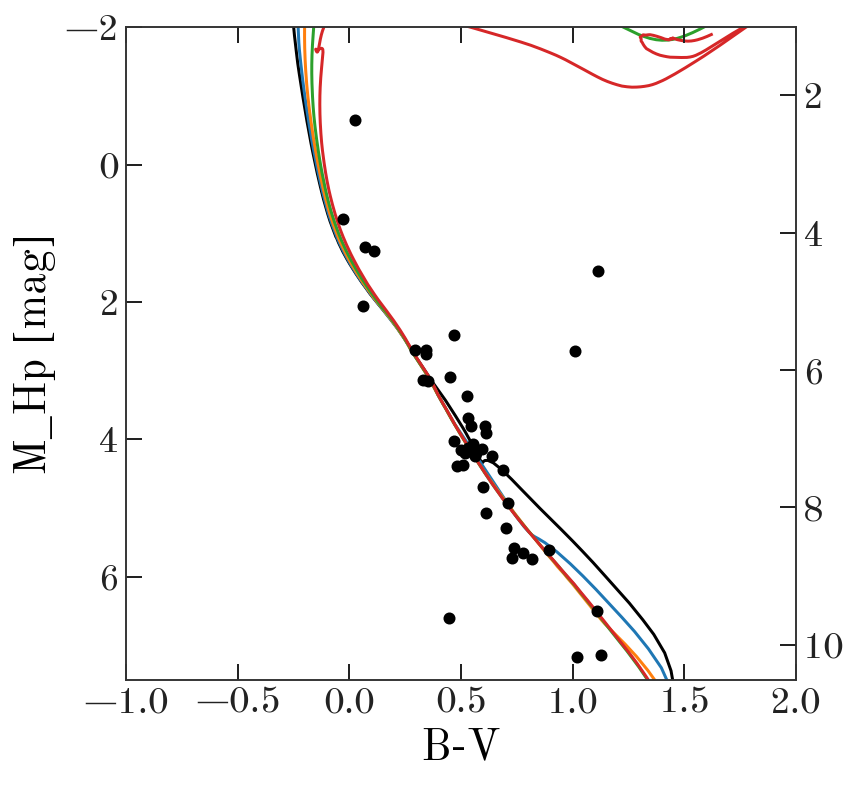

In [469]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.scatter(h['B-V'].value, 
           h['Hpmag'].value - coord.Distance(parallax=h['Plx']).distmod.value)

# boi = h['HIP'] == 71618
# ax.scatter(h['B-V'].value[boi], 
#            (h['Hpmag'].value - coord.Distance(parallax=h['Plx']).distmod.value)[boi],
#            s=300)

for age in np.arange(7.4, 8.2+1e-3, 0.2):
    iso = at.Table.read(f'/Users/apricewhelan/data/Isochrones/MIST/FeH_0.1_iso.fits')
    i = iso[np.isclose(iso['log10_isochrone_age_yr'], age)] 
    i = i[i['phase'] < 4]  # rgb or before
    ax.plot(i['Tycho_B']-i['Tycho_V'], i['Hipparcos_Hp'], 
            marker='', label=f'log10age=${age:.1f}$', zorder=-10)

ax.set_xlim(-1, 2)
ax.set_ylim(7.5, -2)

ax.set_xlabel('B-V')
ax.set_ylabel('M_Hp [mag]')

ax2 = ax.twinx()
ylim = ax.get_ylim()
fid_dm = coord.Distance(40*u.pc).distmod.value
ax2.set_ylim(ylim[0] + fid_dm, 
             ylim[1] + fid_dm)

fig.set_facecolor('w')

Now we have a bunch of candidate members!

In [470]:
highprob_c = g.get_skycoord()

In [481]:
# Absolute magnitude, color - not extinction corrected
mg = g.phot_g_mean_mag - g.distmod
bprp = g.phot_bp_mean_mag - g.phot_rp_mean_mag

# Absolute magnitude, color - extinction corrected
# mg = g.get_G0() - g.distmod
# bprp = g.get_BP0() - g.get_RP0()

mh = g.h_m
jmk = g.j_m - g.ks_m

In [482]:
bperr = 1.086 * g.phot_bp_mean_flux_error / g.phot_bp_mean_flux
rperr = 1.086 * g.phot_rp_mean_flux_error / g.phot_rp_mean_flux
gerr = 1.086 * g.phot_g_mean_flux_error / g.phot_g_mean_flux

distmod_samples = g.get_error_samples(size=16_384)
distmod_err = np.std(distmod_samples.distmod, axis=1)
mgerr = np.sqrt(gerr**2 + distmod_err.value**2)
bprperr = np.sqrt(bperr**2 + rperr**2)

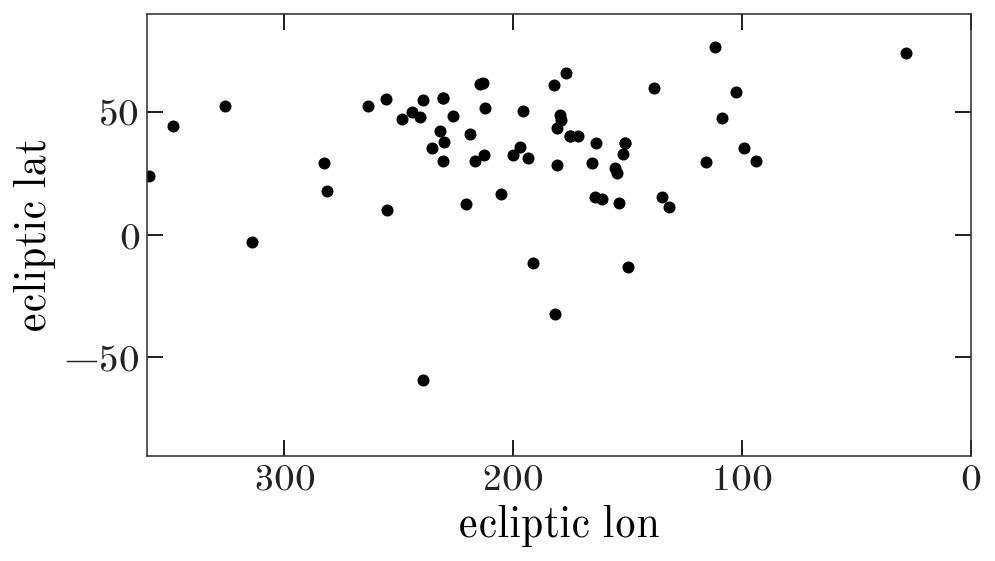

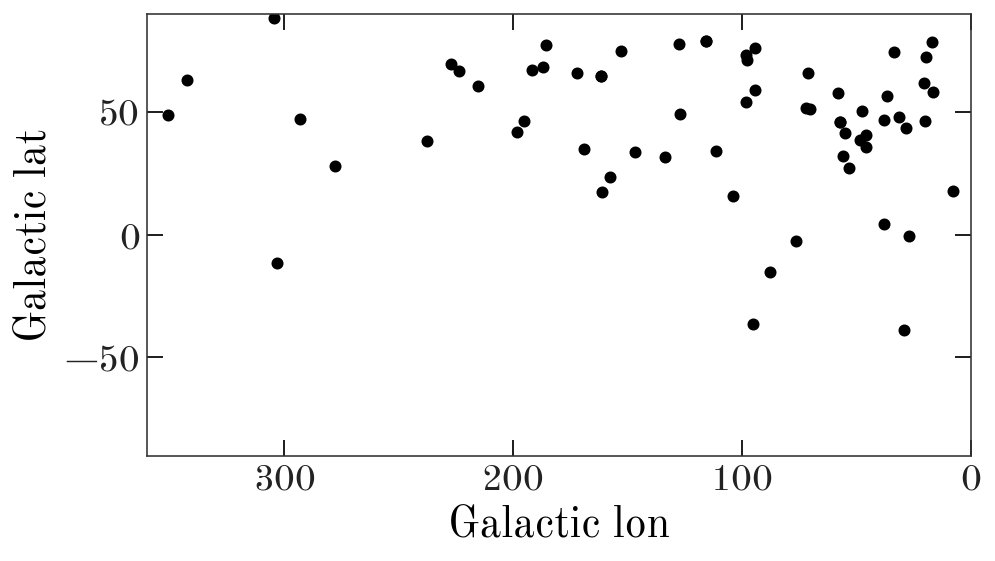

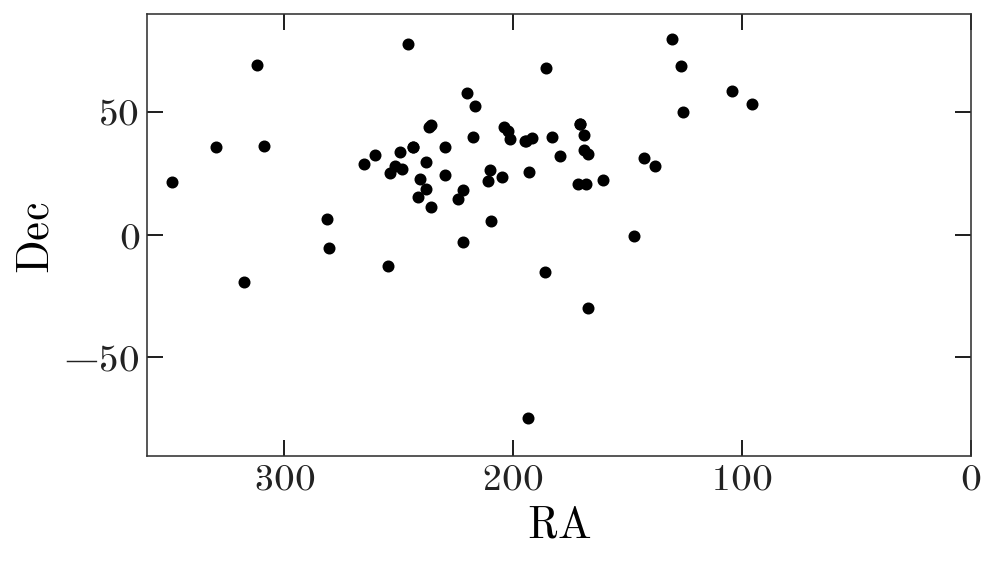

In [483]:
plt.figure(figsize=(7, 4))
plt.scatter(highprob_c.barycentricmeanecliptic.lon.degree,
            highprob_c.barycentricmeanecliptic.lat.degree)
plt.xlim(360, 0)
plt.ylim(-90, 90)
plt.xlabel('ecliptic lon')
plt.ylabel('ecliptic lat')
plt.tight_layout()

plt.figure(figsize=(7, 4))
plt.scatter(highprob_c.galactic.l.degree,
            highprob_c.galactic.b.degree)
plt.xlim(360, 0)
plt.ylim(-90, 90)
plt.xlabel('Galactic lon')
plt.ylabel('Galactic lat')
plt.tight_layout()

plt.figure(figsize=(7, 4))
plt.scatter(highprob_c.ra.degree,
            highprob_c.dec.degree)
plt.xlim(360, 0)
plt.ylim(-90, 90)
plt.xlabel('RA')
plt.ylabel('Dec')
plt.tight_layout()

Color-magnitude diagrams with isochrones:

In [484]:
def make_cmd(color_by=None, color_by_norm=None, color_by_label=None):
    
    if color_by is not None:
        fig, ax = plt.subplots(1, 1, figsize=(9.5, 8), 
                               constrained_layout=True)
        
        cs = ax.scatter(bprp, mg, c=color_by, 
                        cmap='cividis', 
                        norm=color_by_norm,
                        edgecolor='#666666', linewidth=0.5)
    else:
        fig, ax = plt.subplots(1, 1, figsize=(8, 8), 
                           constrained_layout=True)
        
        cs = ax.scatter(bprp, mg, c='k')

    ax.annotate('TIC 2749',
                (bprp[g.source_id == 1490845584382687232].value, 
                 mg[g.source_id == 1490845584382687232].value),
                xytext=(bprp[g.source_id == 1490845584382687232].value + 0.2, 
                        mg[g.source_id == 1490845584382687232].value - 0.4),
                arrowprops=dict(arrowstyle='->', color='#777777'), fontsize=14)

    ax.annotate('TOI 1807',
                (bprp[g.source_id == 1476485996883837184].value, 
                 mg[g.source_id == 1476485996883837184].value),
                xytext=(bprp[g.source_id == 1476485996883837184].value + 0.2, 
                        mg[g.source_id == 1476485996883837184].value - 0.4),
                arrowprops=dict(arrowstyle='->', color='#777777'), fontsize=14)

    ax.set_xlim(-0.5, 3)
    ax.set_ylim(12, -4)

    ax.set_xlabel(r'$G_{\rm BP}-G_{\rm RP}$')
    ax.set_ylabel('$M_G$')

    ax2 = ax.twinx()
    ylim = ax.get_ylim()
    fid_dm = coord.Distance(40*u.pc).distmod.value
    ax2.set_ylim(ylim[0] + fid_dm, 
                 ylim[1] + fid_dm)
    ax2.set_ylabel('~$G$ [mag]')
    
    if color_by is not None:
        cb = fig.colorbar(cs, ax=ax, aspect=40)
        if color_by_label is not None:
            cb.set_label(color_by_label)
    
    fig.set_facecolor('w')
    # fig.tight_layout()
    
    return fig, ax

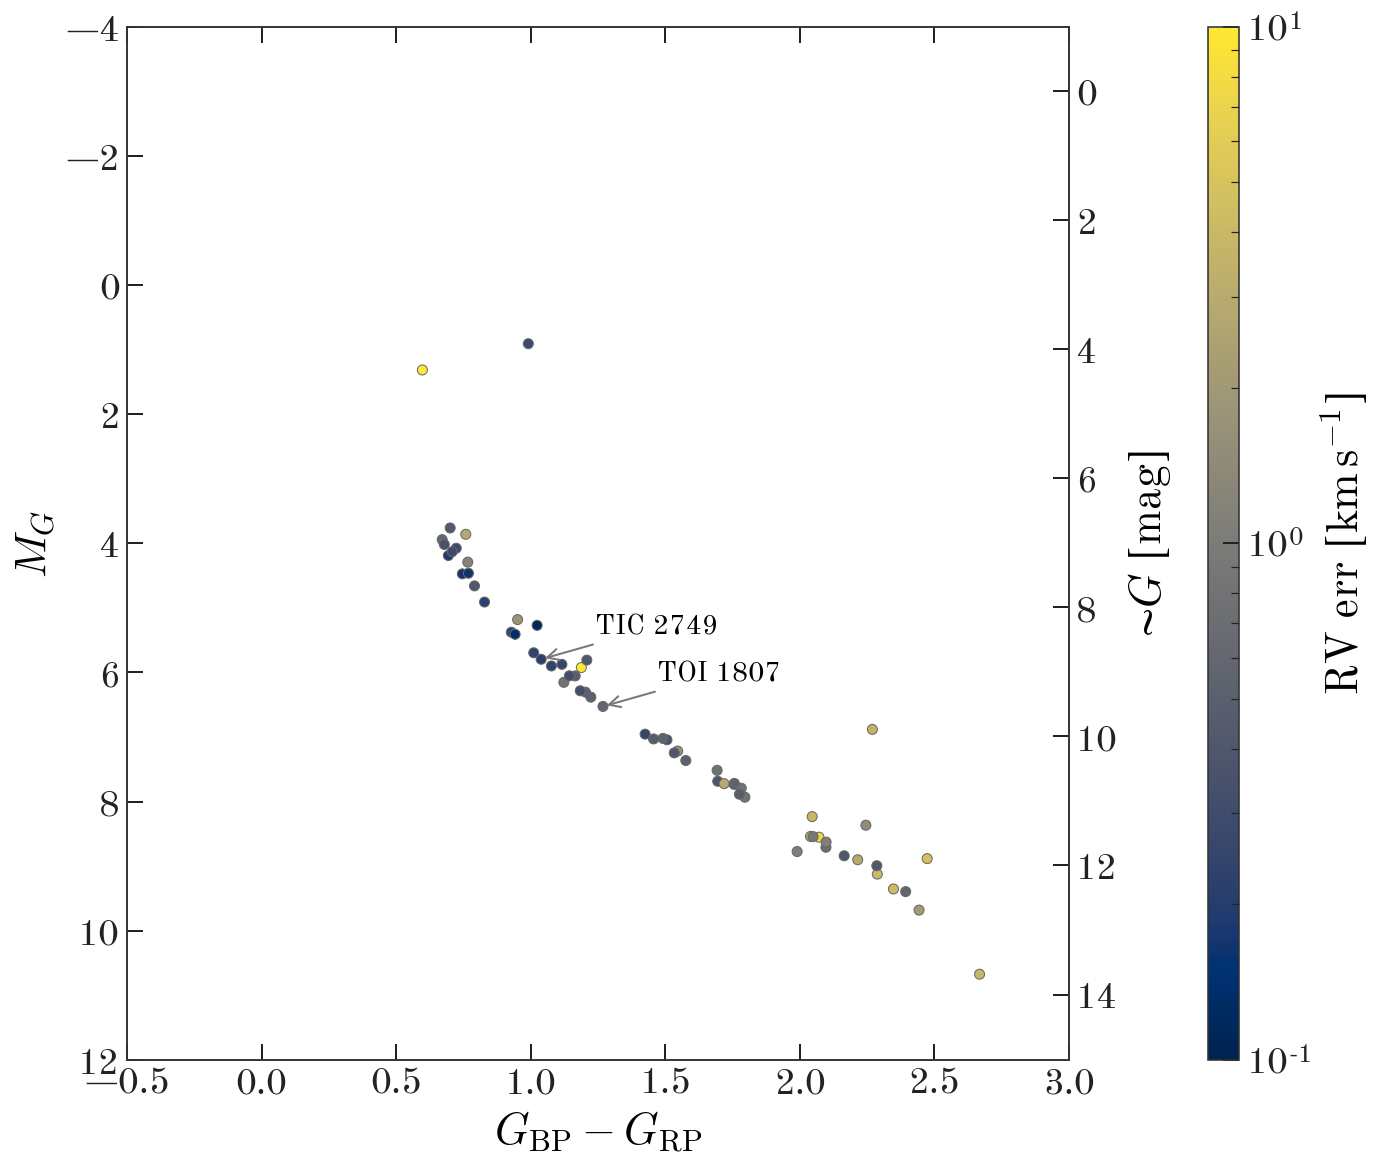

In [485]:
_ = make_cmd(color_by=g.radial_velocity_error.value,
             color_by_norm=mpl.colors.LogNorm(vmin=1e-1, vmax=1e1),
             color_by_label=f'RV err [{u.km/u.s:latex_inline}]')

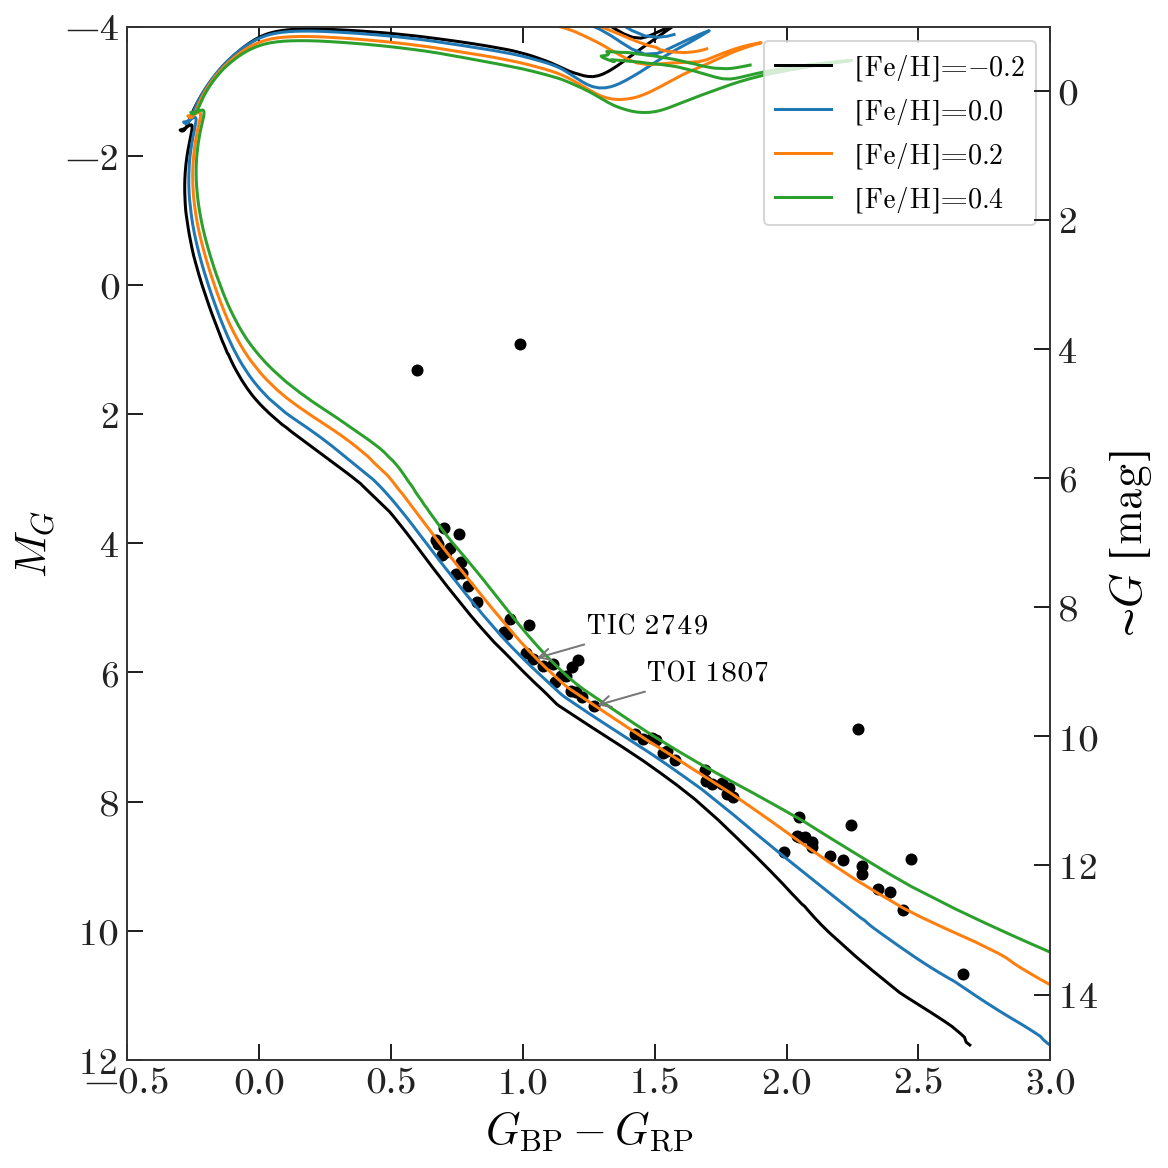

In [486]:
fig, ax = make_cmd()

for feh in np.arange(-0.2, 0.4+1e-3, 0.2):
    iso = at.Table.read(f'/Users/apricewhelan/data/Isochrones/MIST/FeH_{feh:.1f}_iso.fits')
    i = iso[np.isclose(iso['log10_isochrone_age_yr'], 7.8)]  # ~60 Myr
    i = i[i['phase'] < 4]  # rgb or before
    ax.plot(i['G_BP']-i['G_RP'], i['G'], marker='', label=f'[Fe/H]=${feh:.1f}$')

ax.legend(loc='upper right', fontsize=14)

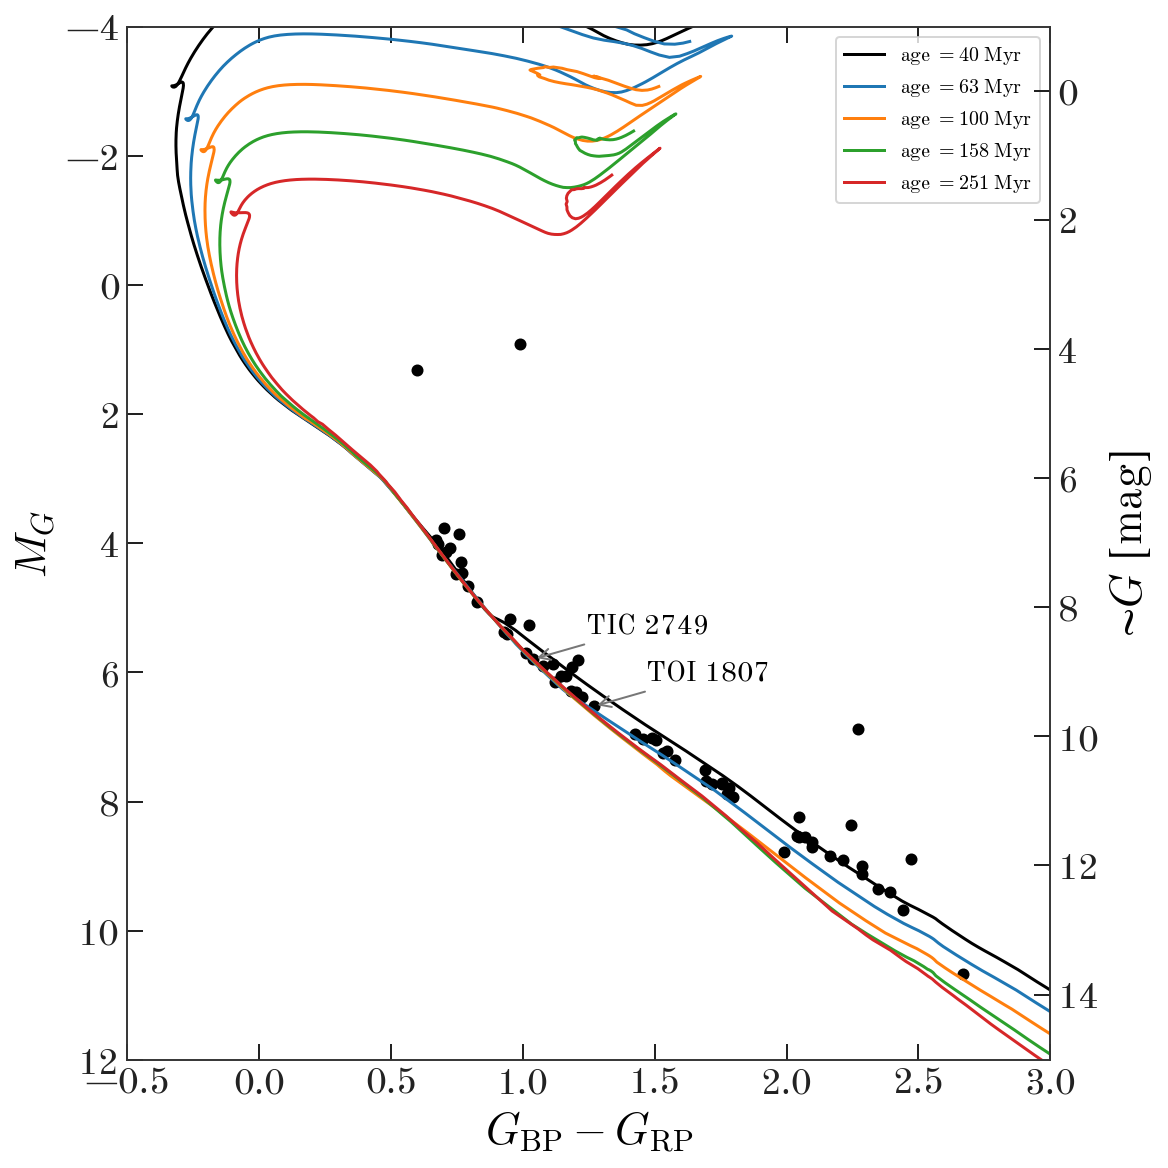

In [487]:
fig, ax = make_cmd()

for age in np.arange(7.6, 8.4+1e-3, 0.2):
    iso = at.Table.read(f'/Users/apricewhelan/data/Isochrones/MIST/FeH_0.1_iso.fits')
    i = iso[np.isclose(iso['log10_isochrone_age_yr'], age)] 
    i = i[i['phase'] < 4]  # rgb or before
    age = 10**age / 1e6
    ax.plot(i['G_BP']-i['G_RP'], i['G'], marker='', label=f'age $={age:.0f}' + r'~{\rm Myr}$')

ax.legend(loc='upper right')

How many brighter stars do we expect?

In [488]:
from scipy.interpolate import interp1d
from tqdm.notebook import trange
import imf

(20.0, -6.0)

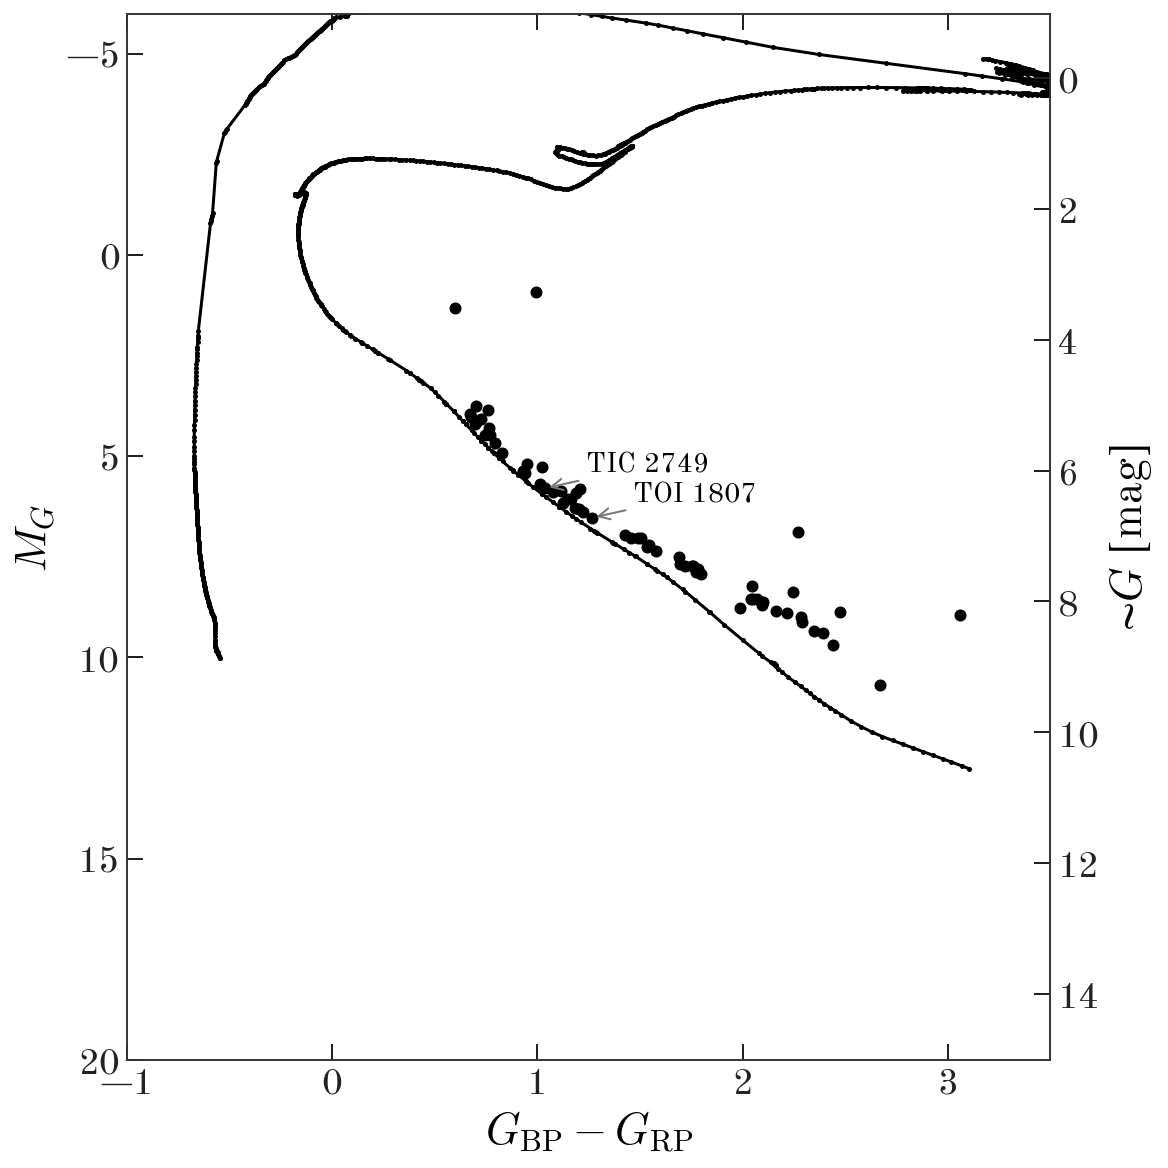

In [490]:
iso = at.Table.read(f'/Users/apricewhelan/data/Isochrones/MIST/FeH_-0.1_iso.fits')
i = iso[np.isclose(iso['log10_isochrone_age_yr'], 8.2)] 

fig, ax = make_cmd()
ax.plot(i['G_BP']-i['G_RP'], i['G'])
ax.set_xlim(-1, 3.5)
ax.set_ylim(20, -6)

In [451]:
iso = at.Table.read(f'/Users/apricewhelan/data/Isochrones/MIST/FeH_-0.1_iso.fits')
i = iso[np.isclose(iso['log10_isochrone_age_yr'], 8.2)] 
i = i[i['phase'] <= 0]  # rgb or before

cluster = imf.make_cluster(10000, massfunc='salpeter')

sim_mags = np.zeros((len(cluster), 3))
for j, f in enumerate(['G', 'G_BP', 'G_RP']):
    interp = interp1d(i['initial_mass'], i[f], kind='cubic', 
                      bounds_error=False)
    sim_mags[:, j] = interp(cluster)
    
sim_mags = sim_mags[np.isfinite(sim_mags[:, 0])]
sim_mags.shape

Total cluster mass is 9993.88 (limit was 10000)


(8897, 3)

In [452]:
glim = (4, 7)
nsim = ((sim_mags[:, 0] > glim[0]) & (sim_mags[:, 0] < glim[1])).sum()
nmg = ((mg.value > glim[0]) & (mg.value < glim[1])).sum()
downsample_fac = int(round(nsim / nmg))
downsample_fac

54

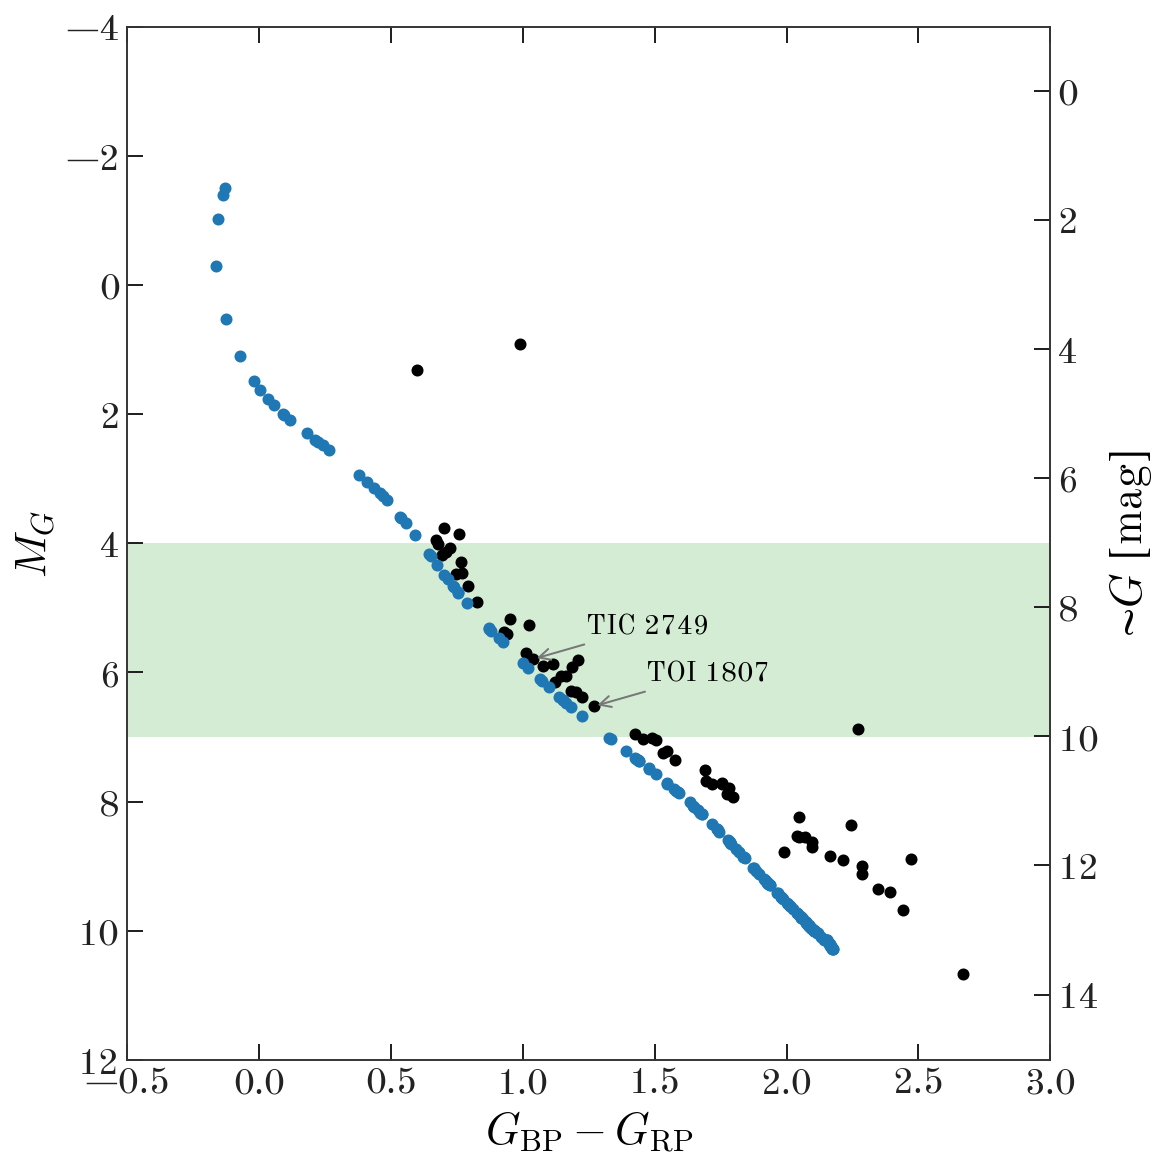

In [453]:
#fig, ax = plt.subplots(figsize=(6, 6))

fig, ax = make_cmd()

derp = sim_mags[::downsample_fac]
ax.scatter(derp[:,1]-derp[:,2], derp[:,0], color='tab:blue')

ax.axhspan(glim[0], glim[1], zorder=-100, 
           color='tab:green', alpha=0.2, lw=0)

# ax.set_xlim(-0.5, 3.)
# ax.set_ylim(12, -4)

In [454]:
counts = {}

for massfunc in ['salpeter', 'kroupa']:
    counts[massfunc] = []
    for trial in trange(1024):
        cluster = imf.make_cluster(10000, massfunc=massfunc)

        sim_mags = np.zeros((len(cluster), 3))
        for j, f in enumerate(['G', 'G_BP', 'G_RP']):
            interp = interp1d(i['initial_mass'], i[f], kind='cubic', 
                              bounds_error=False)
            sim_mags[:, j] = interp(cluster)

        sim_mags = sim_mags[np.isfinite(sim_mags[:, 0])]

        nsim = ((sim_mags[:, 0] > glim[0]) & (sim_mags[:, 0] < glim[1])).sum()
        nmg = ((mg.value > glim[0]) & (mg.value < glim[1])).sum() - 6
        downsample_fac = int(round(nsim / nmg))

        sim_mags = sim_mags[::downsample_fac]
        lim = 6 - coord.Distance(40*u.pc).distmod.value
        counts[massfunc].append((sim_mags[:, 0] < lim).sum())

Total cluster mass is 9999.21 (limit was 10000)
Total cluster mass is 9996.61 (limit was 10000)
Total cluster mass is 10000.3 (limit was 10000)
Total cluster mass is 9999.88 (limit was 10000)
Total cluster mass is 10010.6 (limit was 10000)
Total cluster mass is 9999.8 (limit was 10000)
Total cluster mass is 9995.37 (limit was 10000)
Total cluster mass is 10000.6 (limit was 10000)
Total cluster mass is 10001.4 (limit was 10000)
Total cluster mass is 9999.14 (limit was 10000)
Total cluster mass is 10000 (limit was 10000)
Total cluster mass is 9999.69 (limit was 10000)
Total cluster mass is 10000.1 (limit was 10000)
Total cluster mass is 10000 (limit was 10000)
Total cluster mass is 9999.93 (limit was 10000)
Total cluster mass is 10002.1 (limit was 10000)
Total cluster mass is 10001 (limit was 10000)
Total cluster mass is 10000.1 (limit was 10000)
Total cluster mass is 9999.79 (limit was 10000)
Total cluster mass is 9999.76 (limit was 10000)
Total cluster mass is 10011.4 (limit was 10000)

Total cluster mass is 9999.58 (limit was 10000)
Total cluster mass is 10000.1 (limit was 10000)
Total cluster mass is 10000.9 (limit was 10000)
Total cluster mass is 10000.1 (limit was 10000)
Total cluster mass is 10000.4 (limit was 10000)
Total cluster mass is 10004.1 (limit was 10000)
Total cluster mass is 10006 (limit was 10000)
Total cluster mass is 9999.96 (limit was 10000)
Total cluster mass is 9999.79 (limit was 10000)
Total cluster mass is 9999.89 (limit was 10000)
Total cluster mass is 9999.7 (limit was 10000)
Total cluster mass is 10000.5 (limit was 10000)
Total cluster mass is 9999.56 (limit was 10000)
Total cluster mass is 10000.3 (limit was 10000)
Total cluster mass is 9999.55 (limit was 10000)
Total cluster mass is 10001.8 (limit was 10000)
Total cluster mass is 9999.93 (limit was 10000)
Total cluster mass is 10000.3 (limit was 10000)
Total cluster mass is 10003 (limit was 10000)
Total cluster mass is 9981.8 (limit was 10000)
Total cluster mass is 10000.1 (limit was 10000

Total cluster mass is 10002.6 (limit was 10000)
Total cluster mass is 9997.99 (limit was 10000)
Total cluster mass is 10000.6 (limit was 10000)
Total cluster mass is 10000.3 (limit was 10000)
Total cluster mass is 10006.4 (limit was 10000)
Total cluster mass is 9999.46 (limit was 10000)
Total cluster mass is 9999.82 (limit was 10000)
Total cluster mass is 10000.6 (limit was 10000)
Total cluster mass is 9999.96 (limit was 10000)
Total cluster mass is 9999.69 (limit was 10000)
Total cluster mass is 9999.84 (limit was 10000)
Total cluster mass is 10000 (limit was 10000)
Total cluster mass is 10003.2 (limit was 10000)
Total cluster mass is 10000.1 (limit was 10000)
Total cluster mass is 9999.86 (limit was 10000)
Total cluster mass is 9999.68 (limit was 10000)
Total cluster mass is 9999.77 (limit was 10000)
Total cluster mass is 10000.1 (limit was 10000)
Total cluster mass is 10000.4 (limit was 10000)
Total cluster mass is 9989.38 (limit was 10000)
Total cluster mass is 9999.37 (limit was 1

Total cluster mass is 10001.1 (limit was 10000)
Total cluster mass is 9999.91 (limit was 10000)
Total cluster mass is 10000.1 (limit was 10000)
Total cluster mass is 10002.6 (limit was 10000)
Total cluster mass is 10000.1 (limit was 10000)
Total cluster mass is 9997.26 (limit was 10000)
Total cluster mass is 10008.3 (limit was 10000)
Total cluster mass is 9998.42 (limit was 10000)
Total cluster mass is 9999.85 (limit was 10000)
Total cluster mass is 9991.36 (limit was 10000)
Total cluster mass is 9999.85 (limit was 10000)
Total cluster mass is 10000 (limit was 10000)
Total cluster mass is 9998.37 (limit was 10000)
Total cluster mass is 10000.7 (limit was 10000)
Total cluster mass is 10012.1 (limit was 10000)
Total cluster mass is 10000.3 (limit was 10000)
Total cluster mass is 9999.86 (limit was 10000)
Total cluster mass is 10007.6 (limit was 10000)
Total cluster mass is 9997.98 (limit was 10000)
Total cluster mass is 10002 (limit was 10000)
Total cluster mass is 9989.71 (limit was 100

Total cluster mass is 9999.89 (limit was 10000)
Total cluster mass is 10000.4 (limit was 10000)
Total cluster mass is 10002.8 (limit was 10000)
Total cluster mass is 9995.7 (limit was 10000)
Total cluster mass is 10000.2 (limit was 10000)
Total cluster mass is 10000 (limit was 10000)
Total cluster mass is 10000.2 (limit was 10000)
Total cluster mass is 10036.6 (limit was 10000)
Total cluster mass is 10000.1 (limit was 10000)
Total cluster mass is 9998.96 (limit was 10000)
Total cluster mass is 10000 (limit was 10000)
Total cluster mass is 9998.32 (limit was 10000)
Total cluster mass is 9999.03 (limit was 10000)
Total cluster mass is 9999.95 (limit was 10000)
Total cluster mass is 10000.3 (limit was 10000)
Total cluster mass is 9997.65 (limit was 10000)
Total cluster mass is 10001.4 (limit was 10000)
Total cluster mass is 10036.5 (limit was 10000)
Total cluster mass is 9999.92 (limit was 10000)
Total cluster mass is 9998.28 (limit was 10000)
Total cluster mass is 9999.91 (limit was 1000

Total cluster mass is 9998.03 (limit was 10000)
Total cluster mass is 10000.8 (limit was 10000)
Total cluster mass is 9999.14 (limit was 10000)
Total cluster mass is 10042.9 (limit was 10000)
Total cluster mass is 9999.63 (limit was 10000)
Total cluster mass is 9953.01 (limit was 10000)
Total cluster mass is 9999.08 (limit was 10000)
Total cluster mass is 10000.3 (limit was 10000)
Total cluster mass is 9999.15 (limit was 10000)
Total cluster mass is 9999.18 (limit was 10000)
Total cluster mass is 9994.33 (limit was 10000)
Total cluster mass is 10000.4 (limit was 10000)
Total cluster mass is 9999.4 (limit was 10000)
Total cluster mass is 9999.38 (limit was 10000)
Total cluster mass is 10000.4 (limit was 10000)
Total cluster mass is 9999.99 (limit was 10000)
Total cluster mass is 9998.99 (limit was 10000)
Total cluster mass is 10000 (limit was 10000)
Total cluster mass is 10000.2 (limit was 10000)
Total cluster mass is 9992.48 (limit was 10000)
Total cluster mass is 9993.21 (limit was 10

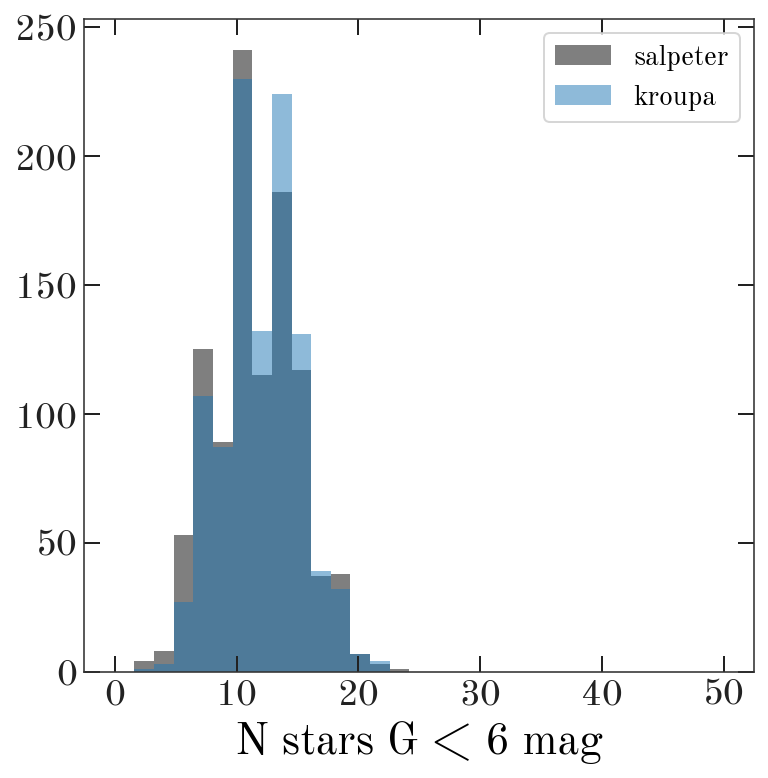

In [441]:
fig = plt.figure(figsize=(6, 6))
for k in counts.keys():
    plt.hist(counts[k], bins=np.linspace(0, 50, 32), label=k, alpha=0.5)
plt.legend(loc='upper right', fontsize=14)
plt.xlabel('N stars G < 6 mag')
fig.set_facecolor('w')

---

In [368]:
g.data[derp_mask].write('../data/TheOGGroup.csv', format='ascii.ecsv', overwrite=True)

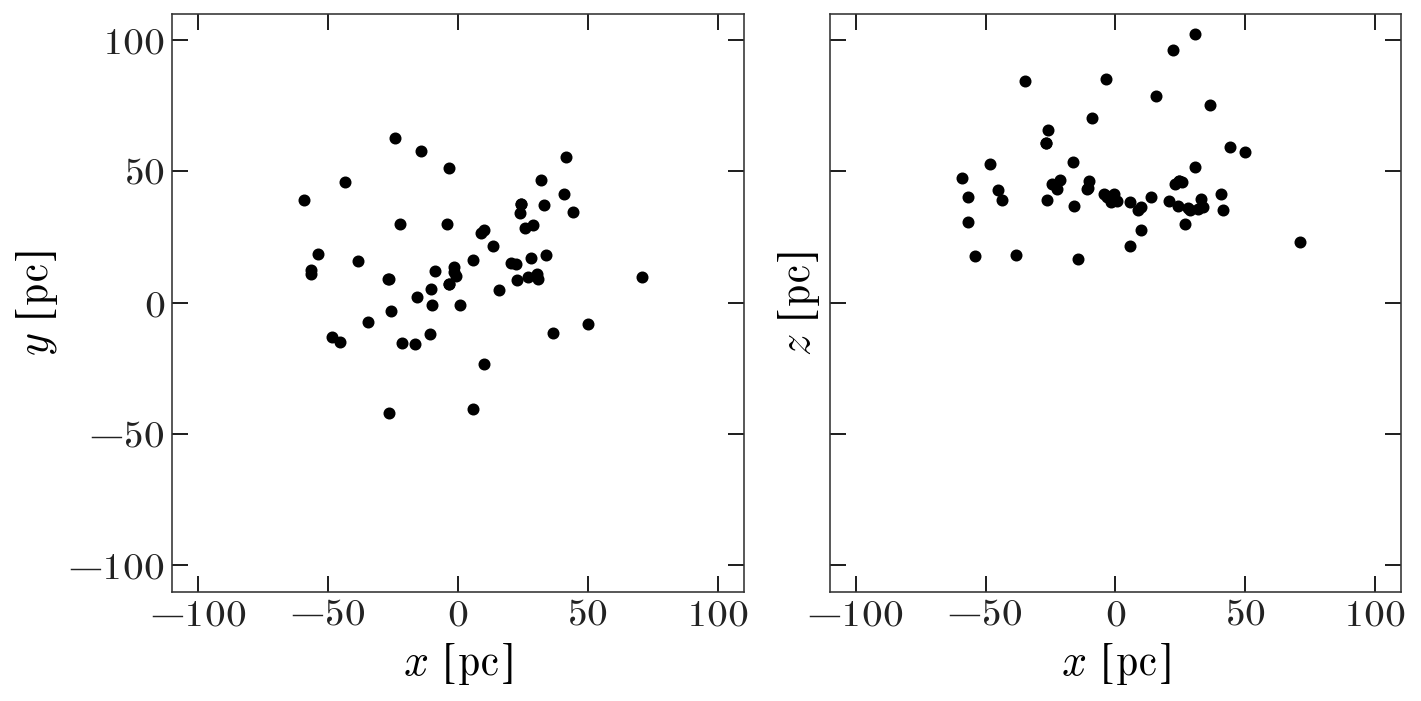

In [365]:
galcen = highprob_c.transform_to(coord.Galactocentric)

fig, axes = plt.subplots(1, 2, figsize=(10, 5),
                         sharex=True, sharey=True)

derp_mask = (galcen.z.to_value(u.pc) > 30)

ax = axes[0]
ax.scatter((galcen.x - -galcen.galcen_distance).to_value(u.pc)[derp_mask],
           galcen.y.to_value(u.pc)[derp_mask])
ax.set_xlim(-110, 110)
ax.set_ylim(-110, 110)
ax.set_xlabel('$x$ [pc]')
ax.set_ylabel('$y$ [pc]')

ax = axes[1]
ax.scatter((galcen.x - -galcen.galcen_distance).to_value(u.pc)[derp_mask],
           galcen.z.to_value(u.pc)[derp_mask] - galcen.z_sun.to_value(u.pc))

ax.set_xlabel('$x$ [pc]')
ax.set_ylabel('$z$ [pc]')

fig.tight_layout()
fig.set_facecolor('w')

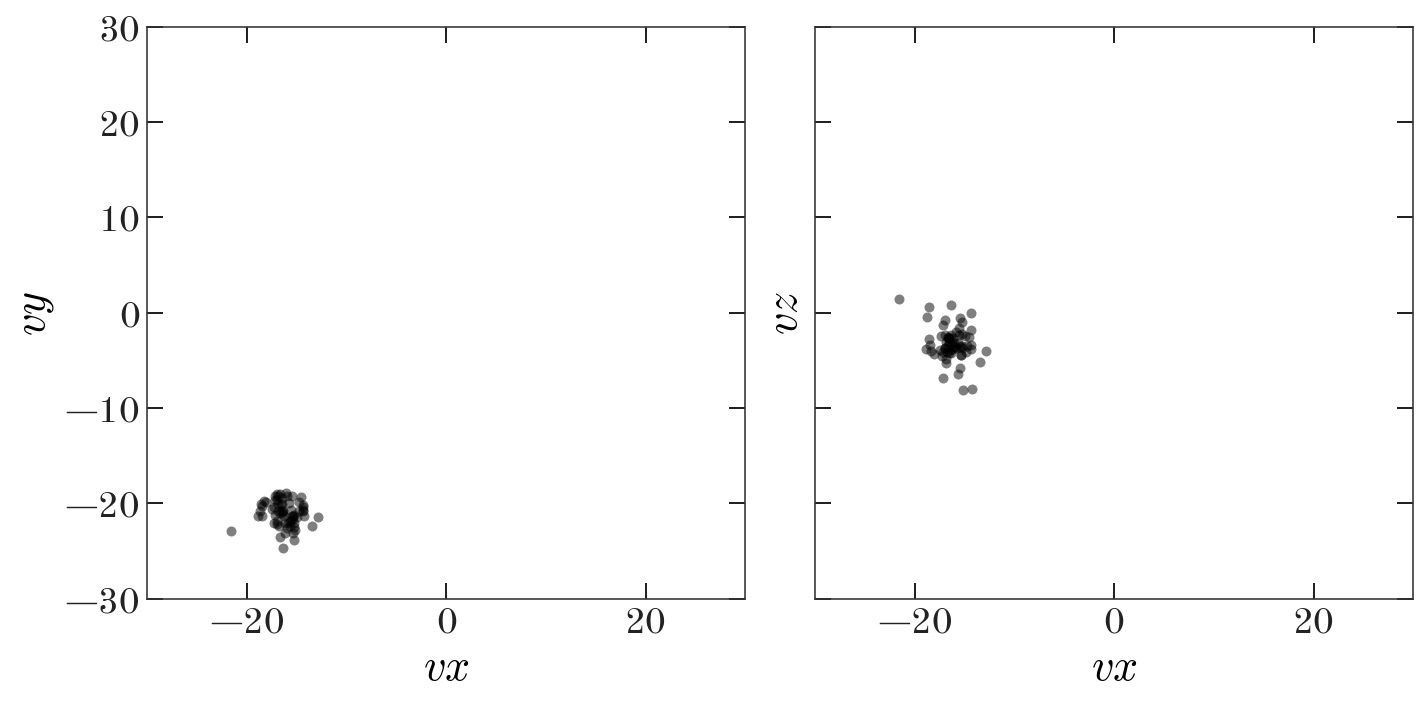

In [334]:
vxyz0 = galcen.galcen_v_sun.d_xyz

fig, axes = plt.subplots(1, 2, figsize=(10, 5),
                         sharex=True, sharey=True)

ax = axes[0]
ax.scatter((galcen.v_x - vxyz0[0]).to_value(u.km/u.s),
           (galcen.v_y - vxyz0[1]).to_value(u.km/u.s),
           alpha=0.5, linewidth=0)
ax.set_xlim(-30, 30)
ax.set_ylim(-30, 30)
ax.set_xlabel('$vx$')
ax.set_ylabel('$vy$')

ax = axes[1]
ax.scatter((galcen.v_x - vxyz0[0]).to_value(u.km/u.s),
           (galcen.v_z - vxyz0[2]).to_value(u.km/u.s),
           alpha=0.5, linewidth=0)

ax.set_xlabel('$vx$')
ax.set_ylabel('$vz$')

fig.tight_layout()
fig.set_facecolor('w')

In [336]:
for x in g.source_id[np.argsort(g.phot_g_mean_mag)][:10]:
    print(f'Gaia DR2 {x}')

Gaia DR2 1002340161664057216
Gaia DR2 995762333350851712
Gaia DR2 1189404610382948224
Gaia DR2 1549259098113618688
Gaia DR2 1610856453920291712
Gaia DR2 3978500258656158720
Gaia DR2 2271062437069059456
Gaia DR2 1329910067425244160
Gaia DR2 758728379683090304
Gaia DR2 1523645047031954944


xmatch with APOGEE, LAMOST, etc.

In [337]:
allstar = at.Table.read('/Users/apricewhelan/data/APOGEE_beta/allStar-r13-l33-58932beta.fits')

In [338]:
np.isin(g.source_id, allstar['GAIA_SOURCE_ID']).sum()

15

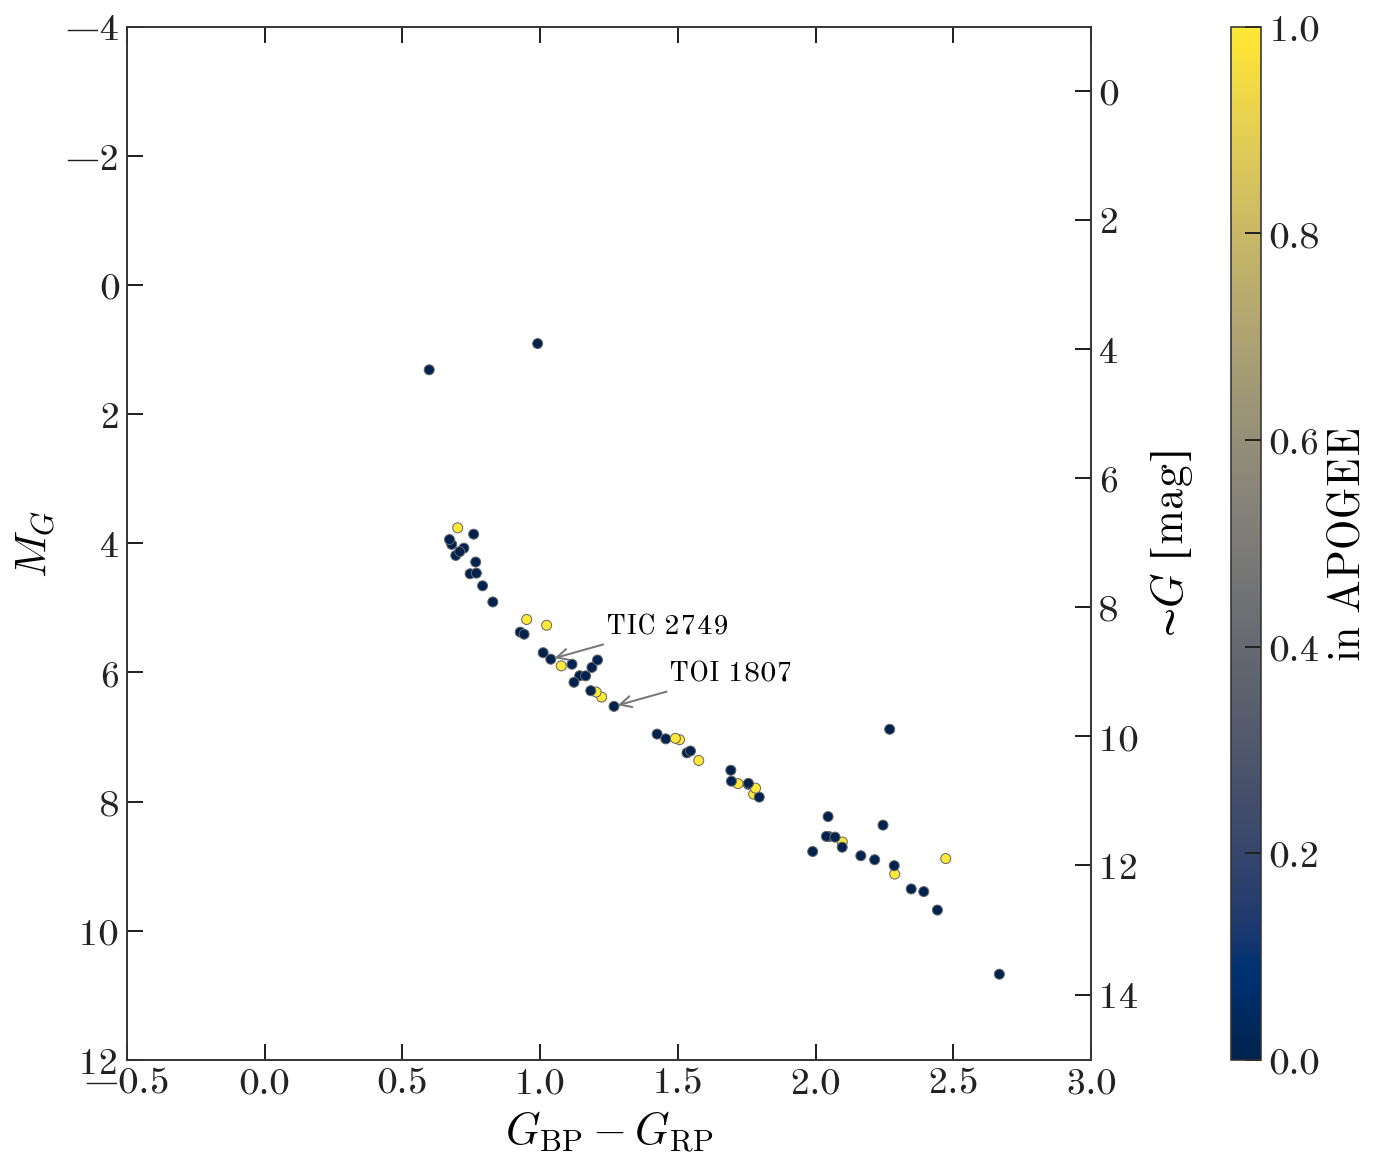

In [374]:
_ = make_cmd(color_by=np.isin(g.source_id, allstar['GAIA_SOURCE_ID']),
             color_by_norm=mpl.colors.Normalize(vmin=0, vmax=1),
             color_by_label=f'in APOGEE')

In [339]:
stars = allstar[np.isin(allstar['GAIA_SOURCE_ID'], g.source_id)]
stars = stars[np.unique(stars['APOGEE_ID'], return_index=True)[1]]

In [343]:
stars['VSINI']

5.1545405
9.0567
8.009216
20.290838
5.0507984
5.7368035
5.903778
6.2188487
16.818995
12.5227585
6.7042465


In [340]:
stars_100pc = allstar[allstar['GAIA_PARALLAX'] > coord.Distance(100*u.pc).parallax.value]
len(stars_100pc)

15811

Text(0, 0.5, '[alpha/M]')

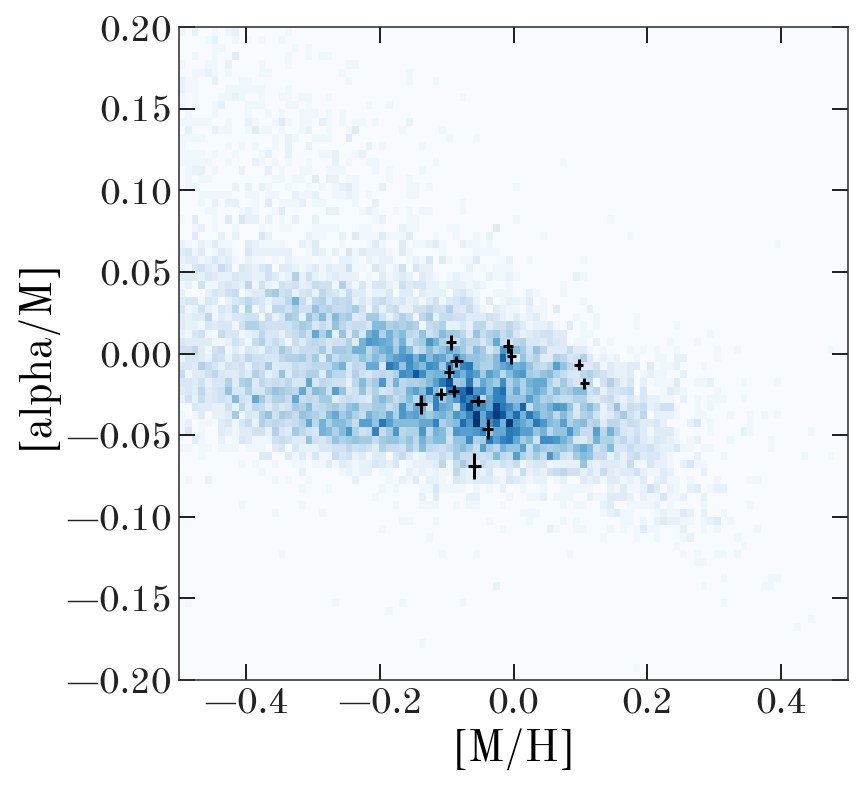

In [341]:
fig, ax = plt.subplots(figsize=(6, 6))

ax.errorbar(stars['M_H'], stars['ALPHA_M'],
            xerr=stars['M_H_ERR'],
            yerr=stars['ALPHA_M_ERR'],
            ls='none', marker='.')

ax.hist2d(stars_100pc['M_H'], stars_100pc['ALPHA_M'],
          bins=(np.arange(-0.5, 0.5+1e-4, 0.01),
                np.arange(-0.2, 0.2+1e-3, 0.005)),
          cmap='Blues', zorder=-10)

ax.set_xlim(-0.5, 0.5)
ax.set_ylim(-0.2, 0.2)

ax.set_xlabel('[M/H]')
ax.set_ylabel('[alpha/M]')

(-0.2, 0.2)

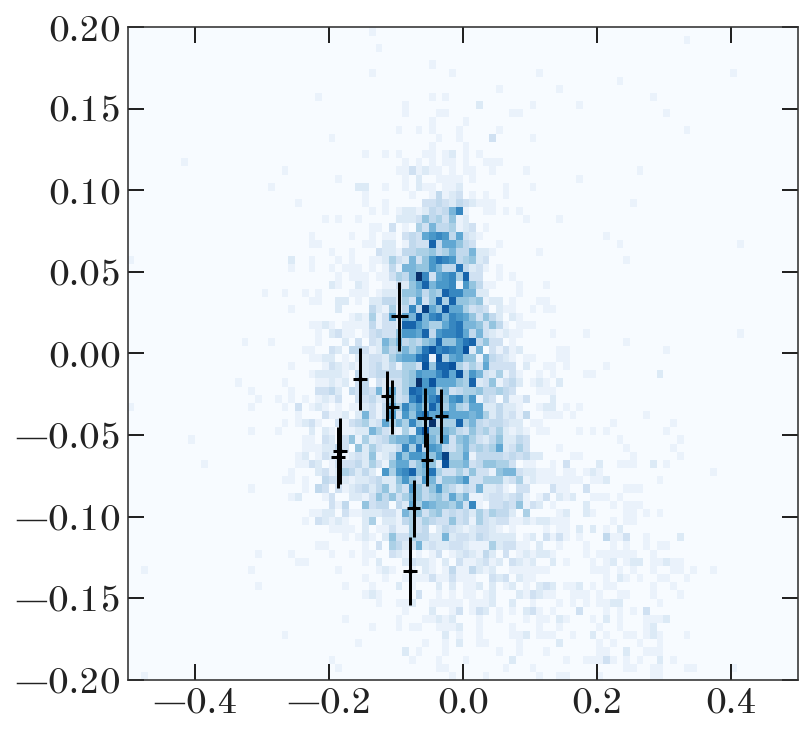

In [344]:
fig, ax = plt.subplots(figsize=(6, 6))

ax.errorbar(stars['MG_FE'], 
            stars['MN_FE'],
            xerr=stars['MG_FE_ERR'],
            yerr=stars['MN_FE_ERR'],
            ls='none', marker='.')

ax.hist2d(stars_100pc['MG_FE'], 
          stars_100pc['MN_FE'],
          bins=(np.arange(-0.5, 0.5+1e-4, 0.01),
                np.arange(-0.2, 0.2+1e-3, 0.005)),
          cmap='Blues', zorder=-10)

ax.set_xlim(-0.5, 0.5)
ax.set_ylim(-0.2, 0.2)

# ax.set_xlabel('[M/H]')
# ax.set_ylabel('[alpha/M]')

Text(0, 0.5, '[Al/Fe]')

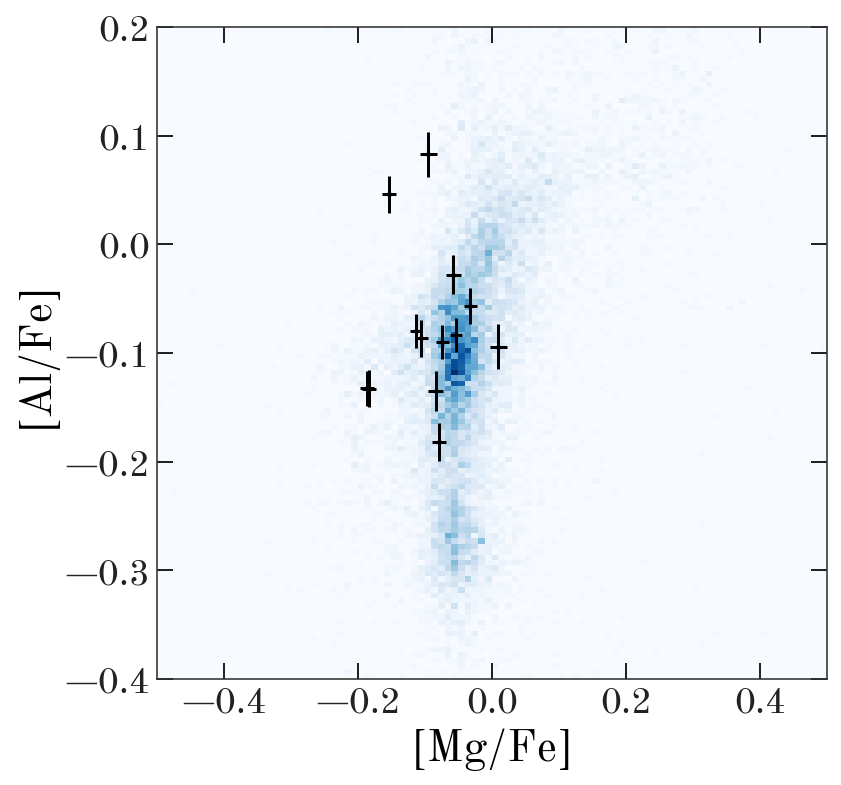

In [384]:
fig, ax = plt.subplots(figsize=(6, 6))

ax.errorbar(stars['MG_FE'], 
            stars['AL_FE'],
            xerr=stars['MG_FE_ERR'],
            yerr=stars['AL_FE_ERR'],
            ls='none', marker='.')

ax.hist2d(stars_100pc['MG_FE'], 
          stars_100pc['AL_FE'],
          bins=(np.arange(-0.5, 0.5+1e-4, 0.01),
                np.arange(-0.4, 0.2+1e-3, 0.005)),
          cmap='Blues', zorder=-10)

ax.set_xlim(-0.5, 0.5)
ax.set_ylim(-0.4, 0.2)

ax.set_xlabel('[Mg/Fe]')
ax.set_ylabel('[Al/Fe]')

TODO: xmatch with 2MASS and remake CMD